In [23]:
import numpy as np
import os.path
import partitura as pt
from basismixer.performance_codec import get_performance_codec
from matplotlib import pyplot as plt
import glob
import re
from scipy import stats
import json

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

In [24]:
xml_fn = glob.glob(os.path.join("asap-dataset", "**", "*.musicxml"), recursive=True)
dump_json = False
perf_parameters = []
piece_dict = {}
match_blacklist = []

for xml in tqdm(xml_fn):
    
    json_dict = {"matches": [], "targets":[], "matched_basis": [], "xml": xml}
    
    os.makedirs(os.path.join(os.path.dirname(xml), "modified_matches"), exist_ok=True)
    
    if not dump_json:
        piece_dict.update({os.path.dirname(xml): {"matches": [], "targets": [], "basis_idxs": [], "xml": xml}})
    
    match_fn = glob.glob(os.path.join(os.path.dirname(xml), "*.match"))

    score = pt.load_score(xml)
    score = pt.score.merge_parts(score)
    score = pt.score.unfold_part_maximal(score, update_ids=True)
    
    nid_dict = dict((n.id, i) for i, n in enumerate(score.notes_tied))
    
    pt.score.expand_grace_notes(score)
    
    basis, bf_names = pt.musicanalysis.make_note_feats(score, "all")

    for match in match_fn:

        try:
            performance, alignment = pt.load_match(match)

            parameter_names = ["velocity_trend", "beat_period"]

            pc = get_performance_codec(parameter_names)

            targets, snote_ids, unique_onset_idxs = pc.encode(
                part=score,
                ppart=performance[0],
                alignment=alignment,
                return_u_onset_idx=True
            )
            
            matched_subset_idxs = np.array([nid_dict[nid] for nid in snote_ids])
            basis_matched = basis[matched_subset_idxs]
            
            perf_parameters.append((targets, match))

        except Exception as e:
            print(e)
            print(match)
            match_blacklist.append(match)
            continue

 69%|███████████████████████████████████████████████████████▏                        | 162/235 [11:17<04:52,  4.00s/it]

need sequence of keys with len > 0 in lexsort
asap-dataset\Debussy\Pour_le_Piano\1\MunA12M.match


 96%|████████████████████████████████████████████████████████████████████████████▉   | 226/235 [18:44<00:37,  4.21s/it]

snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-note(n166,[B,b],4,13799,13860,14020,70). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-no

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 227/235 [18:47<00:29,  3.71s/it]

snote(n1150-1,[B,b],3,100:1,1/10,-1/28,282.388671875,282.25,[])-note(n979,[B,b],3,142779,142817,142817,69). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n1150-1,[B,b],3,100:1,1/10,-1/28,282.388671875,282.25,[])-note(n979,[B,b],3,142779,142817,142817,69). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n1150-1,[B,b],3,100:1,1/10,-1/28,282.388671875,282.25,[])-note(n979,[B,b],3,142779,142817,142817,69). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n1150-1,[B,b],3,100:1,1/10,-1/28,282.388671875,282.25,[])-note(n979,[B,b],3,142779,142817,142817,69). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n1273-1,[B,b],4,110:1,1/10,-1/28,302.388671875,302.25,[])-note(n1096,[B,b],4,151657,151714,151868,80). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, pat

100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [20:50<00:00,  5.32s/it]


In [25]:
import pandas as pd

indices = [perf[1] for perf in perf_parameters]
expressiveness_params = ["beat_period", "timing", "articulation_log", "velocity_trend", "velocity_dev"]
descriptions = []
dataframes = []


for perf in perf_parameters:
    param_df = pd.DataFrame(perf[0], columns=expressiveness_params)
    dataframes.append(param_df)
    descriptions.append(param_df.describe())

In [26]:
dataframes[0]

,beat_period,timing,articulation_log,velocity_trend,velocity_dev
0,1.189583,0.000000,0.511538,0.283465,0.000000
1,1.220833,0.000000,0.266723,0.401575,0.000000
2,1.318750,0.000000,0.183786,0.425197,0.000000
3,1.362500,0.000000,-0.014782,0.448819,0.000000
4,1.125000,0.000000,1.654503,0.346457,0.000000
...,...,...,...,...,...
733,2.354187,0.000000,0.045232,0.393701,0.000000
734,2.716675,0.000000,0.626399,0.370079,0.000000
735,4.270844,0.000000,0.409040,0.511811,0.000000
736,2.763022,-0.009377,-0.002450,0.370079,0.094488


In [37]:
def get_outliers(z_threshold=3):
    
    outlier_dict = {"piece_names": []}
    
    for param_name in expressiveness_params:

        print(f"{param_name} outliers:")

        param_df = pd.DataFrame(columns=["min", "max", "mean"], index=indices)

        param_df["min"] = [desc[param_name].T["min"] for desc in descriptions]
        param_df["max"] = [desc[param_name].T["max"] for desc in descriptions]
        param_df["mean"] = [desc[param_name].T["mean"] for desc in descriptions]
        
        min_mean = np.mean(param_df["min"])
        max_mean = np.mean(param_df["max"])
        mean_mean = np.mean(param_df["mean"])

        z_min = np.abs(stats.zscore(param_df["min"]))
        z_max = np.abs(stats.zscore(param_df["max"]))
        z_mean = np.abs(stats.zscore(param_df["max"]))
        
        outliers = param_df[(z_min > z_threshold) | (z_max > z_threshold) | (z_mean > z_threshold)]
        
        print(f"""Mean values for comparison:
                    min: {min_mean}
                    max: {max_mean}
                    mean: {mean_mean}\n""")
        
        print(f"{outliers.to_markdown()}\n\n")
        outlier_dict[param_name] = outliers
        outlier_dict["piece_names"] += [idx for idx in outliers.index]
        
    return outlier_dict

In [38]:
outlier_dict = get_outliers(8)
outlier_dict["piece_names"] += match_blacklist
outlier_dict["piece_names"] = list(set(outlier_dict["piece_names"]))

beat_period outliers:
Mean values for comparison:
                    min: 0.08845793854084578
                    max: 6.147560077058169
                    mean: 0.5860606074375284

|                                                                 |       min |       max |     mean |
|:----------------------------------------------------------------|----------:|----------:|---------:|
| asap-dataset\Bach\Prelude\bwv_867\Sham01M.match                 | 1.44687   |   4.74057 | 1.80204  |
| asap-dataset\Beethoven\Piano_Sonatas\31-3_4\ParkH01.match       | 0.0729164 | 100.613   | 0.510107 |
| asap-dataset\Beethoven\Piano_Sonatas\31-3_4\Stahievitch02.match | 0.0917155 | 102.25    | 0.471247 |


timing outliers:
Mean values for comparison:
                    min: -1.6791039600884174
                    max: 0.9968757537463697
                    mean: -0.0007879691453345395

|                                                                   |      min |       max |       mean |
|:-------

In [36]:
outlier_dict["piece_names"]

['asap-dataset\\Beethoven\\Piano_Sonatas\\31-3_4\\AbdelmoulaJS05M.match',
 'asap-dataset\\Beethoven\\Piano_Sonatas\\31-3_4\\Stahievitch02.match',
 'asap-dataset\\Beethoven\\Piano_Sonatas\\31-3_4\\LeungM05M.match',
 'asap-dataset\\Beethoven\\Piano_Sonatas\\31-3_4\\Gokcin01.match',
 'asap-dataset\\Beethoven\\Piano_Sonatas\\31-3_4\\HuangSW10M.match',
 'asap-dataset\\Beethoven\\Piano_Sonatas\\31-3_4\\CHOE03.match',
 'asap-dataset\\Debussy\\Pour_le_Piano\\1\\MunA12M.match',
 'asap-dataset\\Beethoven\\Piano_Sonatas\\31-3_4\\ParkH01.match',
 'asap-dataset\\Beethoven\\Piano_Sonatas\\31-3_4\\Zuber04M.match',
 'asap-dataset\\Bach\\Prelude\\bwv_867\\Sham01M.match']

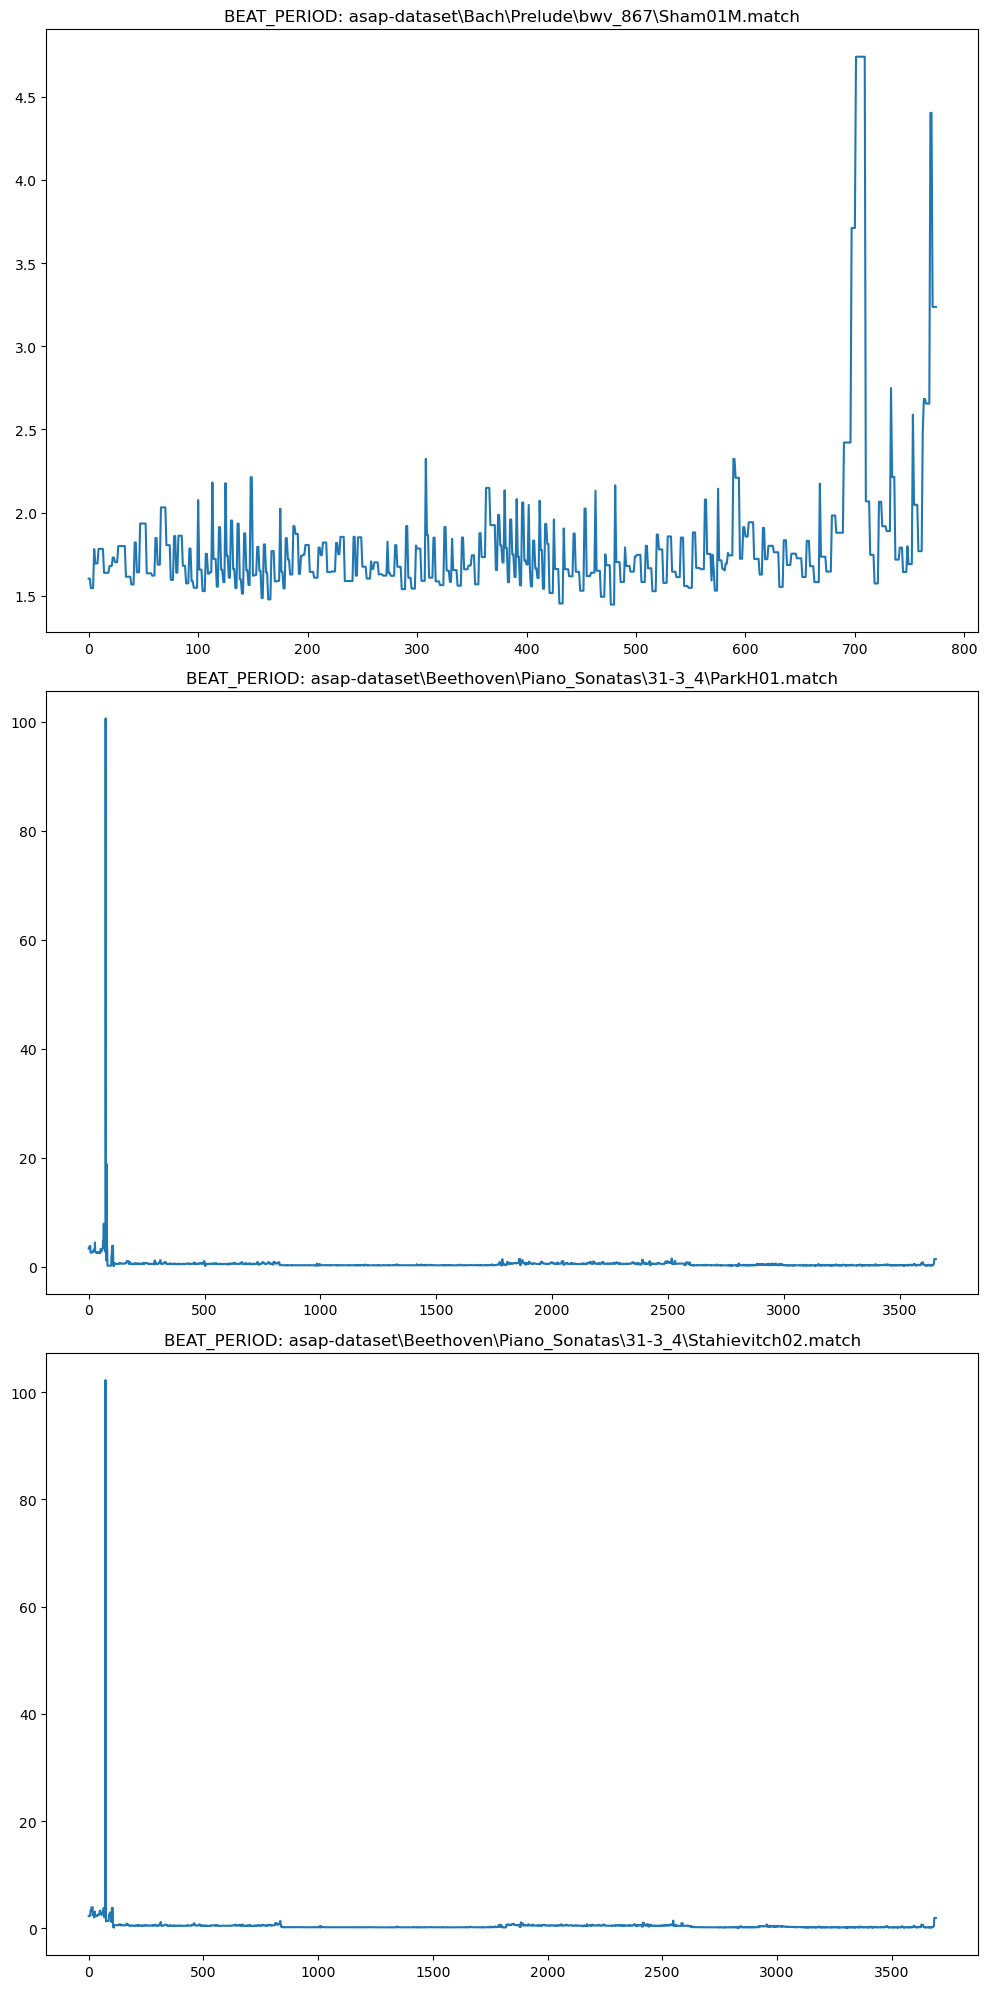

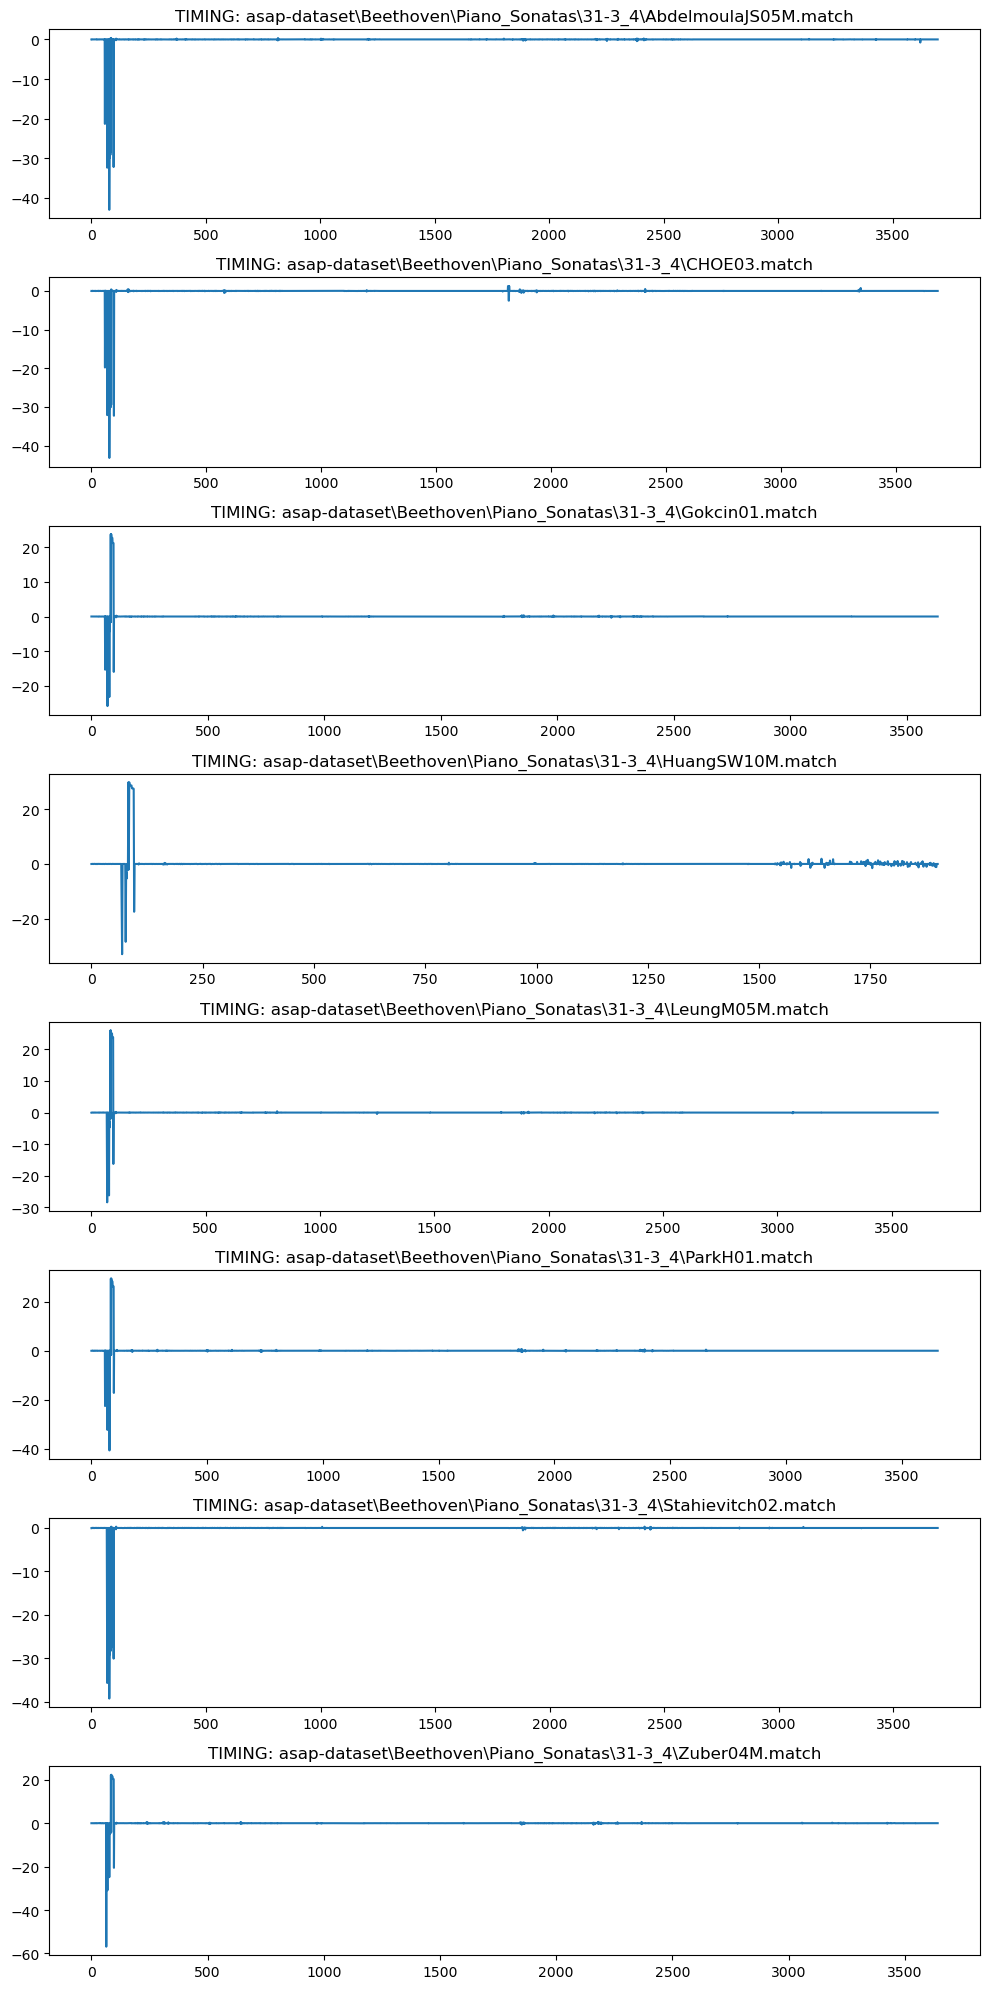

In [34]:
from matplotlib import pyplot as plt

for param_name in expressiveness_params:
    
    if len(outlier_dict[param_name]) != 0:
    
        fig, ax = plt.subplots(len(outlier_dict[param_name]), figsize=(10, 20))
        for i, piece_name in enumerate(outlier_dict[param_name].index):

            idx = indices.index(piece_name)
            df = dataframes[idx]

            ax[i].plot(df[param_name])
            ax[i].set(title=f"{param_name.upper()}: {piece_name}")

        fig.tight_layout()

In [13]:
import shutil
os.makedirs("test_folder", exist_ok=True)
os.makedirs(os.path.join("test_folder", "xml_files"), exist_ok=True)
os.makedirs(os.path.join("test_folder", "match_files"), exist_ok=True)

for match, name in perf_parameters:
    
    xml = glob.glob(os.path.join(os.path.dirname(match), ))

['articulation_direction_feature',
 'articulation_feature',
 'duration_feature',
 'fermata_feature',
 'grace_feature',
 'loudness_direction_feature',
 'metrical_feature',
 'metrical_strength_feature',
 'onset_feature',
 'ornament_feature',
 'polynomial_pitch_feature',
 'relative_score_position_feature',
 'slur_feature',
 'staff_feature',
 'tempo_direction_feature',
 'time_signature_feature',
 'vertical_neighbor_feature']

In [21]:
valid_perf_params = [perf for perf in perf_parameters if perf[1] not in outlier_dict["piece_names"]]

print(len(perf_parameters), len(valid_perf_params))

1062 1053


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    
    def __init__(self,
                 match_paths,
                 seq_len, param_names=["beat_period", "timing", "articulation_log", "velocity_trend", "velocity_dev"],
                 feat_names="all"):
        
        self.data = []
        self.target_data = None
        self.param_names = param_names
        self.parameter_dict = {name: [] for name in param_names}
        
        print("Processing score data...")
        for match_file in tqdm(match_paths):
            
            try:
                
                xml = glob.glob(os.path.join(os.path.dirname(match_file), "*.musicxml"))[0]

                score = pt.load_score(xml)
                score = pt.score.merge_parts(score)
                score = pt.score.unfold_part_maximal(score, update_ids=True)

                nid_dict = dict((n.id, i) for i, n in enumerate(score.notes_tied))

                pt.score.expand_grace_notes(score)

                basis, bf_names = pt.musicanalysis.make_note_feats(score, feat_names, force_fixed_size=False)

                performance, alignment = pt.load_match(match_file)

                parameter_names = param_names

                pc = get_performance_codec(parameter_names)

                targets, snote_ids, unique_onset_idxs = pc.encode(
                    part=score,
                    ppart=performance[0],
                    alignment=alignment,
                    return_u_onset_idx=True
                )

                matched_subset_idxs = np.array([nid_dict[nid] for nid in snote_ids])
                basis_matched = basis[matched_subset_idxs]
                
            except Exception as e:
                print(match_file)
                print(e)
                continue
            
            padding_len = len(targets) % seq_len
            
            for name in param_names:
                new_targets = targets[name]
                t_padding_array = np.zeros(shape=seq_len - padding_len)
                new_targets = np.concatenate((new_targets, t_padding_array))
                new_targets = np.split(new_targets, len(new_targets) / seq_len)
                
                self.parameter_dict[name] += [target for target in new_targets]
                
            bm_padding_array = np.zeros(shape=(seq_len - padding_len, basis_matched.shape[1]))
            new_basis = np.vstack((basis_matched, bm_padding_array))
            new_basis = np.split(new_basis, len(new_basis) / seq_len)
            
            self.data += [basis for basis in new_basis]
            
        max_features = max([basis.shape[1] for basis in self.data])
        
        for i, basis in enumerate(self.data):
            if basis.shape[1] < max_features:
                
                difference = max_features - basis.shape[1]
                
                self.data[i] = np.hstack((basis, np.zeros(shape=(seq_len, difference))))
            
    def choose_parameter(self, parameter_name):
        self.target_data = self.parameter_dict[parameter_name]
        
    def __getitem__(self, idx):
        
        x = self.data[idx]
        y = self.target_data[idx]
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [4]:
matches = glob.glob(os.path.join("asap-dataset", "**", "*.match"), recursive=True)

custom_dataset = MyDataset(matches, seq_len=50)

Processing score data...


 70%|██████████████████████████████████████████████████████▉                        | 740/1063 [27:19<12:54,  2.40s/it]

asap-dataset\Debussy\Pour_le_Piano\1\MunA12M.match
need sequence of keys with len > 0 in lexsort


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1030/1063 [51:15<01:23,  2.54s/it]

snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-note(n166,[B,b],4,13799,13860,14020,70). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-no

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1031/1063 [51:17<01:13,  2.29s/it]

snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4551,4599,4599,68). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4551,4599,4599,68). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4551,4599,4599,68). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4551,4599,4599,68). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-note(n166,[B,b],4,13397,13467,13596,74). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-no

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1032/1063 [51:18<01:04,  2.09s/it]

snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,6552,6591,6591,69). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,6552,6591,6591,69). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,6552,6591,6591,69). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,6552,6591,6591,69). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-note(n165,[B,b],4,15133,15167,15296,80). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-no

100%|████████████████████████████████████████████████████████████████████████████| 1063/1063 [1:10:26<00:00,  3.98s/it]


In [5]:
torch.save(custom_dataset, "my_data.pt")

In [80]:
custom_dataset.choose_parameter("beat_period")
custom_dataset.__getitem__(22)

(array([[ 0.,  0.,  0., ..., 65., 57.,  8.],
        [ 0.,  0.,  0., ..., 73., 58., 15.],
        [ 0.,  0.,  0., ..., 73., 58., 15.],
        ...,
        [ 0.,  0.,  0., ..., 72., 51., 21.],
        [ 0.,  0.,  0., ..., 73., 53., 20.],
        [ 0.,  0.,  0., ..., 73., 53., 20.]]),
 array([0.54792023, 0.41041565, 0.41041565, 0.59791565, 0.34375   ,
        0.34375   , 0.60833359, 0.47083664, 0.47083664, 0.48333359,
        0.48333359, 0.44166183, 0.44166183, 0.50416946, 0.50416946,
        0.46874619, 0.46874619, 0.46875   , 0.46875   , 0.40834045,
        0.40834045, 0.5541687 , 0.5541687 , 0.49582672, 0.49582672,
        0.48750305, 0.43332672, 0.43332672, 0.5291748 , 0.5291748 ,
        0.49582672, 0.49582672, 0.45417023, 0.43332672, 0.43332672,
        0.5145874 , 0.4520874 , 0.4520874 , 0.49999237, 0.49999237,
        0.40833282, 0.40833282, 0.56667328, 0.56667328, 0.45417023,
        0.45417023, 0.46666718, 0.46666718, 0.3999939 , 0.3999939 ]))

In [6]:
custom_dataset.__getitem__(1)[1].dtype

dtype('float64')

In [6]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device).to(x.dtype)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device).to(x.dtype)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(self.relu(out[:, -1, :]))
        return out

Training model for beat_period

Epoch [1/100], Average train Loss: 0.2872, Average validation Loss: 0.2184
Epoch [2/100], Average train Loss: 0.2411, Average validation Loss: 0.2048
Epoch [3/100], Average train Loss: 0.2204, Average validation Loss: 0.1660
Epoch [4/100], Average train Loss: 0.1956, Average validation Loss: 0.1601
Epoch [5/100], Average train Loss: 0.1869, Average validation Loss: 0.1527
Epoch [6/100], Average train Loss: 0.1826, Average validation Loss: 0.1616
Epoch [7/100], Average train Loss: 0.1926, Average validation Loss: 0.1414
Epoch [8/100], Average train Loss: 0.1831, Average validation Loss: 0.1715
Epoch [9/100], Average train Loss: 0.2000, Average validation Loss: 0.1633
Epoch [10/100], Average train Loss: 0.1825, Average validation Loss: 0.1664
Epoch [11/100], Average train Loss: 0.1721, Average validation Loss: 0.1358
Epoch [12/100], Average train Loss: 0.1666, Average validation Loss: 0.1334
Epoch [13/100], Average train Loss: 0.1655, Average validation Lo

Epoch [8/100], Average train Loss: 0.0356, Average validation Loss: 0.0253
Epoch [9/100], Average train Loss: 0.0349, Average validation Loss: 0.0252
Epoch [10/100], Average train Loss: 0.0347, Average validation Loss: 0.0253
Epoch [11/100], Average train Loss: 0.0342, Average validation Loss: 0.0254
Epoch [12/100], Average train Loss: 0.0337, Average validation Loss: 0.0254
Epoch [13/100], Average train Loss: 0.0333, Average validation Loss: 0.0255
Epoch [14/100], Average train Loss: 0.0328, Average validation Loss: 0.0258
Epoch [15/100], Average train Loss: 0.0326, Average validation Loss: 0.0255
Epoch [16/100], Average train Loss: 0.0323, Average validation Loss: 0.0256
Epoch [17/100], Average train Loss: 0.0321, Average validation Loss: 0.0258
Epoch [18/100], Average train Loss: 0.0319, Average validation Loss: 0.0260
Epoch [19/100], Average train Loss: 0.0315, Average validation Loss: 0.0256
Test loss is increasing, stopping early...
Training finished

Average loss on test set: 0.

Epoch [17/100], Average train Loss: 0.0107, Average validation Loss: 0.0112
Epoch [18/100], Average train Loss: 0.0106, Average validation Loss: 0.0112
Epoch [19/100], Average train Loss: 0.0105, Average validation Loss: 0.0111
Epoch [20/100], Average train Loss: 0.0104, Average validation Loss: 0.0109
Epoch [21/100], Average train Loss: 0.0104, Average validation Loss: 0.0109
Epoch [22/100], Average train Loss: 0.0103, Average validation Loss: 0.0107
Epoch [23/100], Average train Loss: 0.0102, Average validation Loss: 0.0107
Epoch [24/100], Average train Loss: 0.0102, Average validation Loss: 0.0105
Epoch [25/100], Average train Loss: 0.0101, Average validation Loss: 0.0105
Epoch [26/100], Average train Loss: 0.0100, Average validation Loss: 0.0108
Epoch [27/100], Average train Loss: 0.0099, Average validation Loss: 0.0105
Epoch [28/100], Average train Loss: 0.0099, Average validation Loss: 0.0105
Epoch [29/100], Average train Loss: 0.0098, Average validation Loss: 0.0105
Epoch [30/10

Epoch [24/100], Average train Loss: 0.0060, Average validation Loss: 0.0060
Epoch [25/100], Average train Loss: 0.0060, Average validation Loss: 0.0060
Epoch [26/100], Average train Loss: 0.0059, Average validation Loss: 0.0060
Epoch [27/100], Average train Loss: 0.0059, Average validation Loss: 0.0060
Epoch [28/100], Average train Loss: 0.0059, Average validation Loss: 0.0059
Epoch [29/100], Average train Loss: 0.0059, Average validation Loss: 0.0059
Epoch [30/100], Average train Loss: 0.0058, Average validation Loss: 0.0059
Epoch [31/100], Average train Loss: 0.0058, Average validation Loss: 0.0059
Epoch [32/100], Average train Loss: 0.0058, Average validation Loss: 0.0059
Epoch [33/100], Average train Loss: 0.0058, Average validation Loss: 0.0059
Epoch [34/100], Average train Loss: 0.0058, Average validation Loss: 0.0059
Epoch [35/100], Average train Loss: 0.0057, Average validation Loss: 0.0058
Epoch [36/100], Average train Loss: 0.0057, Average validation Loss: 0.0058
Epoch [37/10

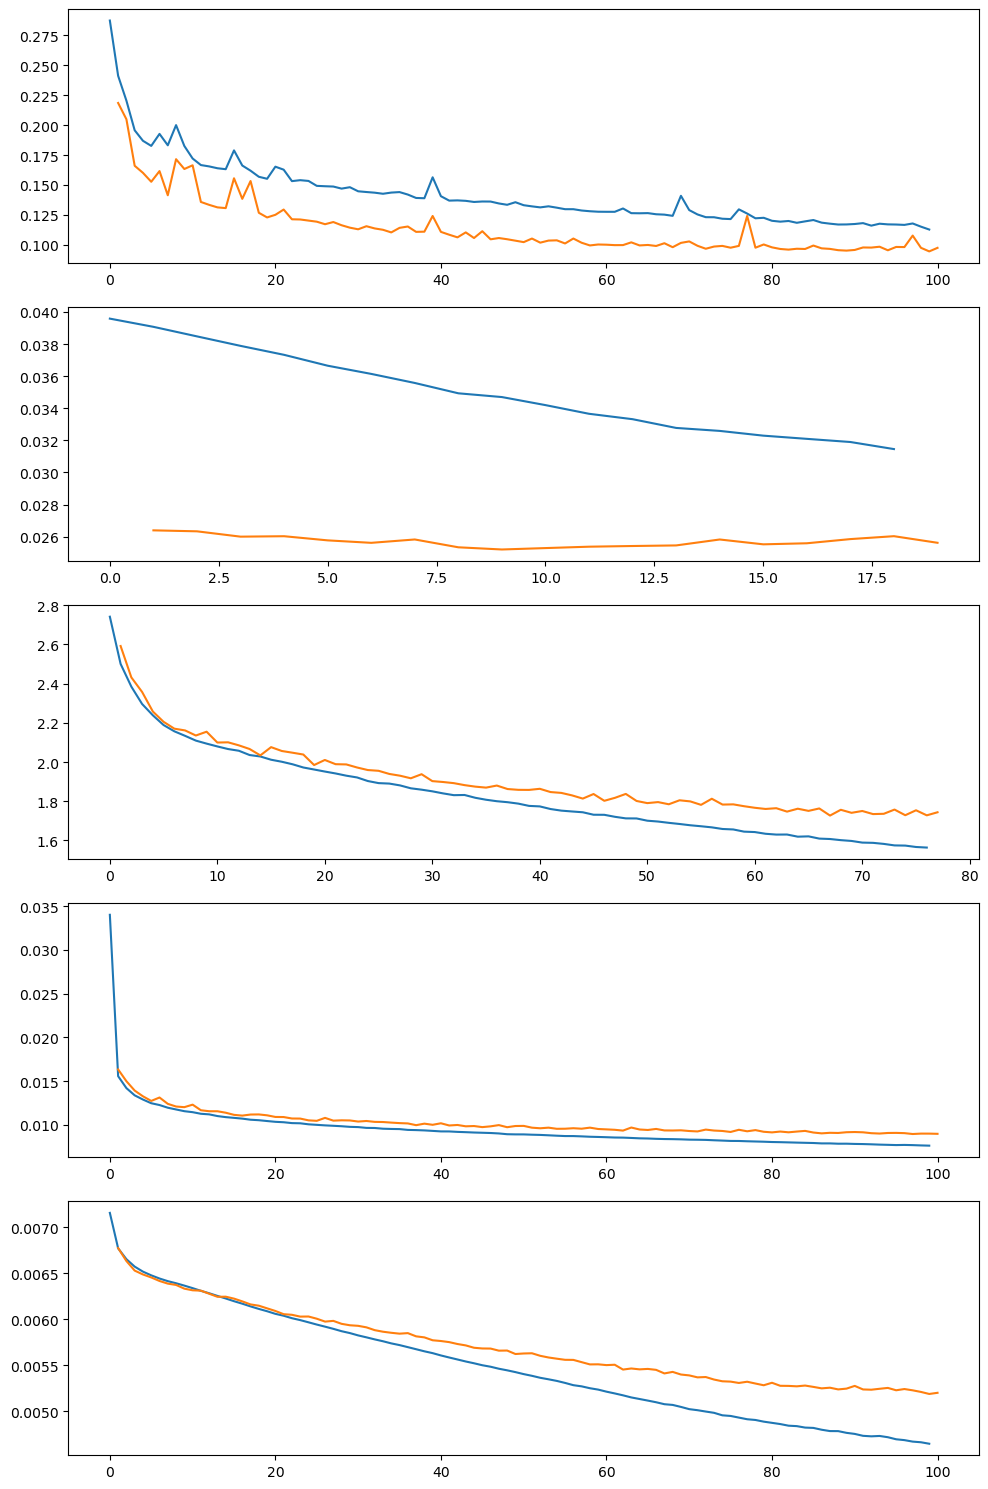

In [9]:
import torch.optim as optim
from torch.utils.data import Subset

models = []
param_names = ["beat_period", "timing", "articulation_log", "velocity_trend", "velocity_dev"]
fig, ax = plt.subplots(5, figsize=(10, 15))

for i, name in enumerate(param_names):
    
    print(f"Training model for {name}\n")
    
    custom_dataset.choose_parameter(name)

    rng = np.random.default_rng()
    all_indices = list(range(len(custom_dataset)))
    rng.shuffle(all_indices)

    test_indices = all_indices[:int(len(all_indices) * 0.2)]
    val_indices = all_indices[int(len(all_indices) * 0.2):int(len(all_indices) * 0.3)]
    train_indices = all_indices[int(len(all_indices) * 0.3):]

    lstm_model = LSTMModel(input_size=138, hidden_size=264, num_layers=2, output_size=50)

    train_set = Subset(custom_dataset, indices=train_indices)
    test_set = Subset(custom_dataset, indices=test_indices)
    val_set = Subset(custom_dataset, indices=val_indices)

    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    learning_rate = 1e-4
    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

    # Training loop
    num_epochs = 100
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    lstm_model.to(device)

    train_losses = []
    val_losses = [np.inf]
    best_model = None
    best_val_loss = np.inf

    # Train/Validation loop
    for epoch in range(num_epochs):

        # Training
        total_train_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = inputs.float(), targets.float()

            # Forward pass
            outputs = lstm_model(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())  # Assuming the output and target shapes are compatible

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Validating
        total_val_loss = 0
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = inputs.float(), targets.float()

            # Forward pass
            outputs = lstm_model(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())

            total_val_loss += loss.item()

        if total_val_loss / len(val_loader) < best_val_loss:
            best_model = lstm_model.state_dict()

        if len(val_losses) > 10 and min(val_losses) not in val_losses[-10:]:
            print("Test loss is increasing, stopping early...")
            break

        print(f"Epoch [{epoch + 1}/{num_epochs}], Average train Loss: {total_train_loss / len(train_loader):.4f}, Average validation Loss: {total_val_loss / len(val_loader):.4f}")
        train_losses.append(total_train_loss / len(train_loader))
        val_losses.append(total_val_loss / len(val_loader))

    print("Training finished\n")
    torch.save(best_model, f"best_model_{name}.pt")

    # Testing
    model = LSTMModel(input_size=138, hidden_size=264, num_layers=2, output_size=50)
    model.load_state_dict(best_model)
    
    total_test_loss = 0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = inputs.float(), targets.float()

        # Forward pass
        outputs = lstm_model(inputs)
        loss = criterion(outputs.squeeze(), targets.squeeze())

        total_test_loss += loss.item()

    print(f"Average loss on test set: {total_test_loss / len(test_loader)}\n\n")
    models.append(model)
    
    ax[i].plot(train_losses)
    ax[i].plot(val_losses)
    
fig.tight_layout()

In [10]:
new_dataset = Subset(custom_dataset, list(range(20)))
new_dataloader = DataLoader(new_dataset, shuffle=False, batch_size=1)

param_names = ["beat_period", "timing", "articulation_log", "velocity_trend", "velocity_dev"]
preds = {name: [] for name in param_names}

for inputs, targets in new_dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs, targets = inputs.float(), targets.float()
    
    for model, name in zip(models, param_names):
        model.to(device)
        outputs = model(inputs)
        
        preds[name] += outputs.tolist()[0]

zipped_list = [(a, b, c, d, e) for a, b, c, d, e in zip(preds["beat_period"], preds["timing"], preds["articulation_log"], preds["velocity_trend"], preds["velocity_dev"])]

In [11]:
test_perf = np.array(zipped_list, dtype=perf_parameters[0][0].dtype)
test_perf["beat_period"] = np.abs(test_perf["beat_period"])
test_perf["velocity_trend"] = np.abs(test_perf["velocity_trend"])
test_perf["velocity_dev"] = np.abs(test_perf["velocity_dev"])

In [20]:
xml = glob.glob(os.path.join("asap-dataset", "Bach", "Fugue", "bwv_846", "*.musicxml"))[0]

score = pt.load_score(xml)
score = pt.score.merge_parts(score)
score = pt.score.unfold_part_maximal(score, update_ids=True)
pt.score.expand_grace_notes(score)

pc = get_performance_codec(param_names)

result = pc.decode(score, test_perf)

In [21]:
test_perf

array([(1.0472146 ,  3.1677559e-03, -0.8234567 , 0.481079  , 0.00840334),
       (1.0495027 ,  4.0032640e-03, -0.735742  , 0.47550288, 0.02733363),
       (1.026562  , -6.4451136e-03, -0.7576897 , 0.47131217, 0.00415402),
       (0.97246695, -6.6065602e-04, -0.6244505 , 0.48071992, 0.02146434),
       (0.97564507, -3.1567365e-04, -0.63287544, 0.48214376, 0.05084325),
       (0.9600794 , -4.8956880e-03, -0.6742983 , 0.48323375, 0.00683494),
       (0.9776279 , -1.5705824e-05, -0.6992618 , 0.49646863, 0.01532708),
       (0.97646207, -8.5260067e-03, -0.77415   , 0.4995461 , 0.02188988),
       (0.96300036,  1.7457269e-03, -0.74723905, 0.49650207, 0.00407854),
       (0.88922435,  4.6820170e-04, -0.7494745 , 0.4916755 , 0.04468454),
       (0.91900706, -5.2935332e-03, -0.82865113, 0.49815798, 0.01652909),
       (0.914004  , -5.4268539e-04, -0.8773133 , 0.48432052, 0.04057121),
       (0.9486711 ,  2.5555482e-03, -0.8770621 , 0.47052428, 0.00733268),
       (0.92639184,  4.4556358e-03, -0

In [22]:
pt.save_performance_midi(result, "test_midi.mid")

In [248]:
result